<a href="https://colab.research.google.com/github/DomMc97/Car_Data/blob/master/RF/RF_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Random Forest Classification

A classification of the quality of car from a set of descriptors using Random Forest classification.

The data set contains a record of the rating of a series of cars by a car dealer into the following categories: 'unacceptable', 'acceptable', 'good', or 'very good' this is the target. The data set also contains the following descriptors for each car:

* buying: buying price
* maint: price of the maintenance
* doors: number of doors
* persons: capacity in terms of persons to carry
* lug_boot: the size of luggage boot
* safety: estimated safety of the car

---



## Set up

Import Libraries

In [1]:
# scientific library
import numpy as np

# data analytics library
import pandas as pd
pd.set_option('precision', 5) # 5 decimal place display precision

# sklearn functions
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn import metrics

# plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
sns.set() #sets design of figures

# libraries for saving/loading data
import pickle
from google.colab import drive

Mount Google Drive.

In [2]:
# mount drive
drive.mount('/content/drive')

# root of all file paths used in notebook
root = '/content/drive/My Drive/Methods for Data Science/CW2/Data/'

Mounted at /content/drive


Asks user whether this is the first run of the code to avoid repeat computations.

In [3]:
# code reapeats until a valid input is inserted for the question.
while True:
    init_run = input('Is this the first run of the code y/n?\n')

    if init_run == 'y':
        init_run = True
        break
    elif init_run == 'n':
        init_run = False
        break
    else:
        print('Invalid input.\n')

Is this the first run of the code y/n?
n


Importation of processed data.

In [4]:
# upload files
X_train = np.load(root + 'X_train.npy')
y_train = np.load(root + 'y_train.npy')
X_test = np.load(root + 'X_test.npy')
y_test = np.load(root + 'y_test.npy')

## Overview of Random Forest Classification


To first understand Random Forest Classification it is required to understand decision trees.

<u>Decision Trees </u>

Denote the classification problem as taking a data point $\vec{x} = (x_{1} ... x_{p})$ and predicting a class $y$.

The decision tree incrementally compartmentalises the feature space into set of regions which fills the whole space. 

The figure below visualises this for a 2D feature space. Where we first split the space into 2 regions based on a condtion. That is $R_{1} = \{\vec{x} = (x_{1},x_{2}) : x_{1} \leq s_{1}\}$ and $R_{2} = \{\vec{x} = (x_{1},x_{2}) : x_{1} > s_{1}\}$. We then split up region $R_{1} \rightarrow R_{11}, R_{12}$ and so forth. At the final step the modal class will be the predicted class for a sample. To make a prediction for a new sample the prediction will be the modal class of the final region the sample is in at the end of the decision tree.  








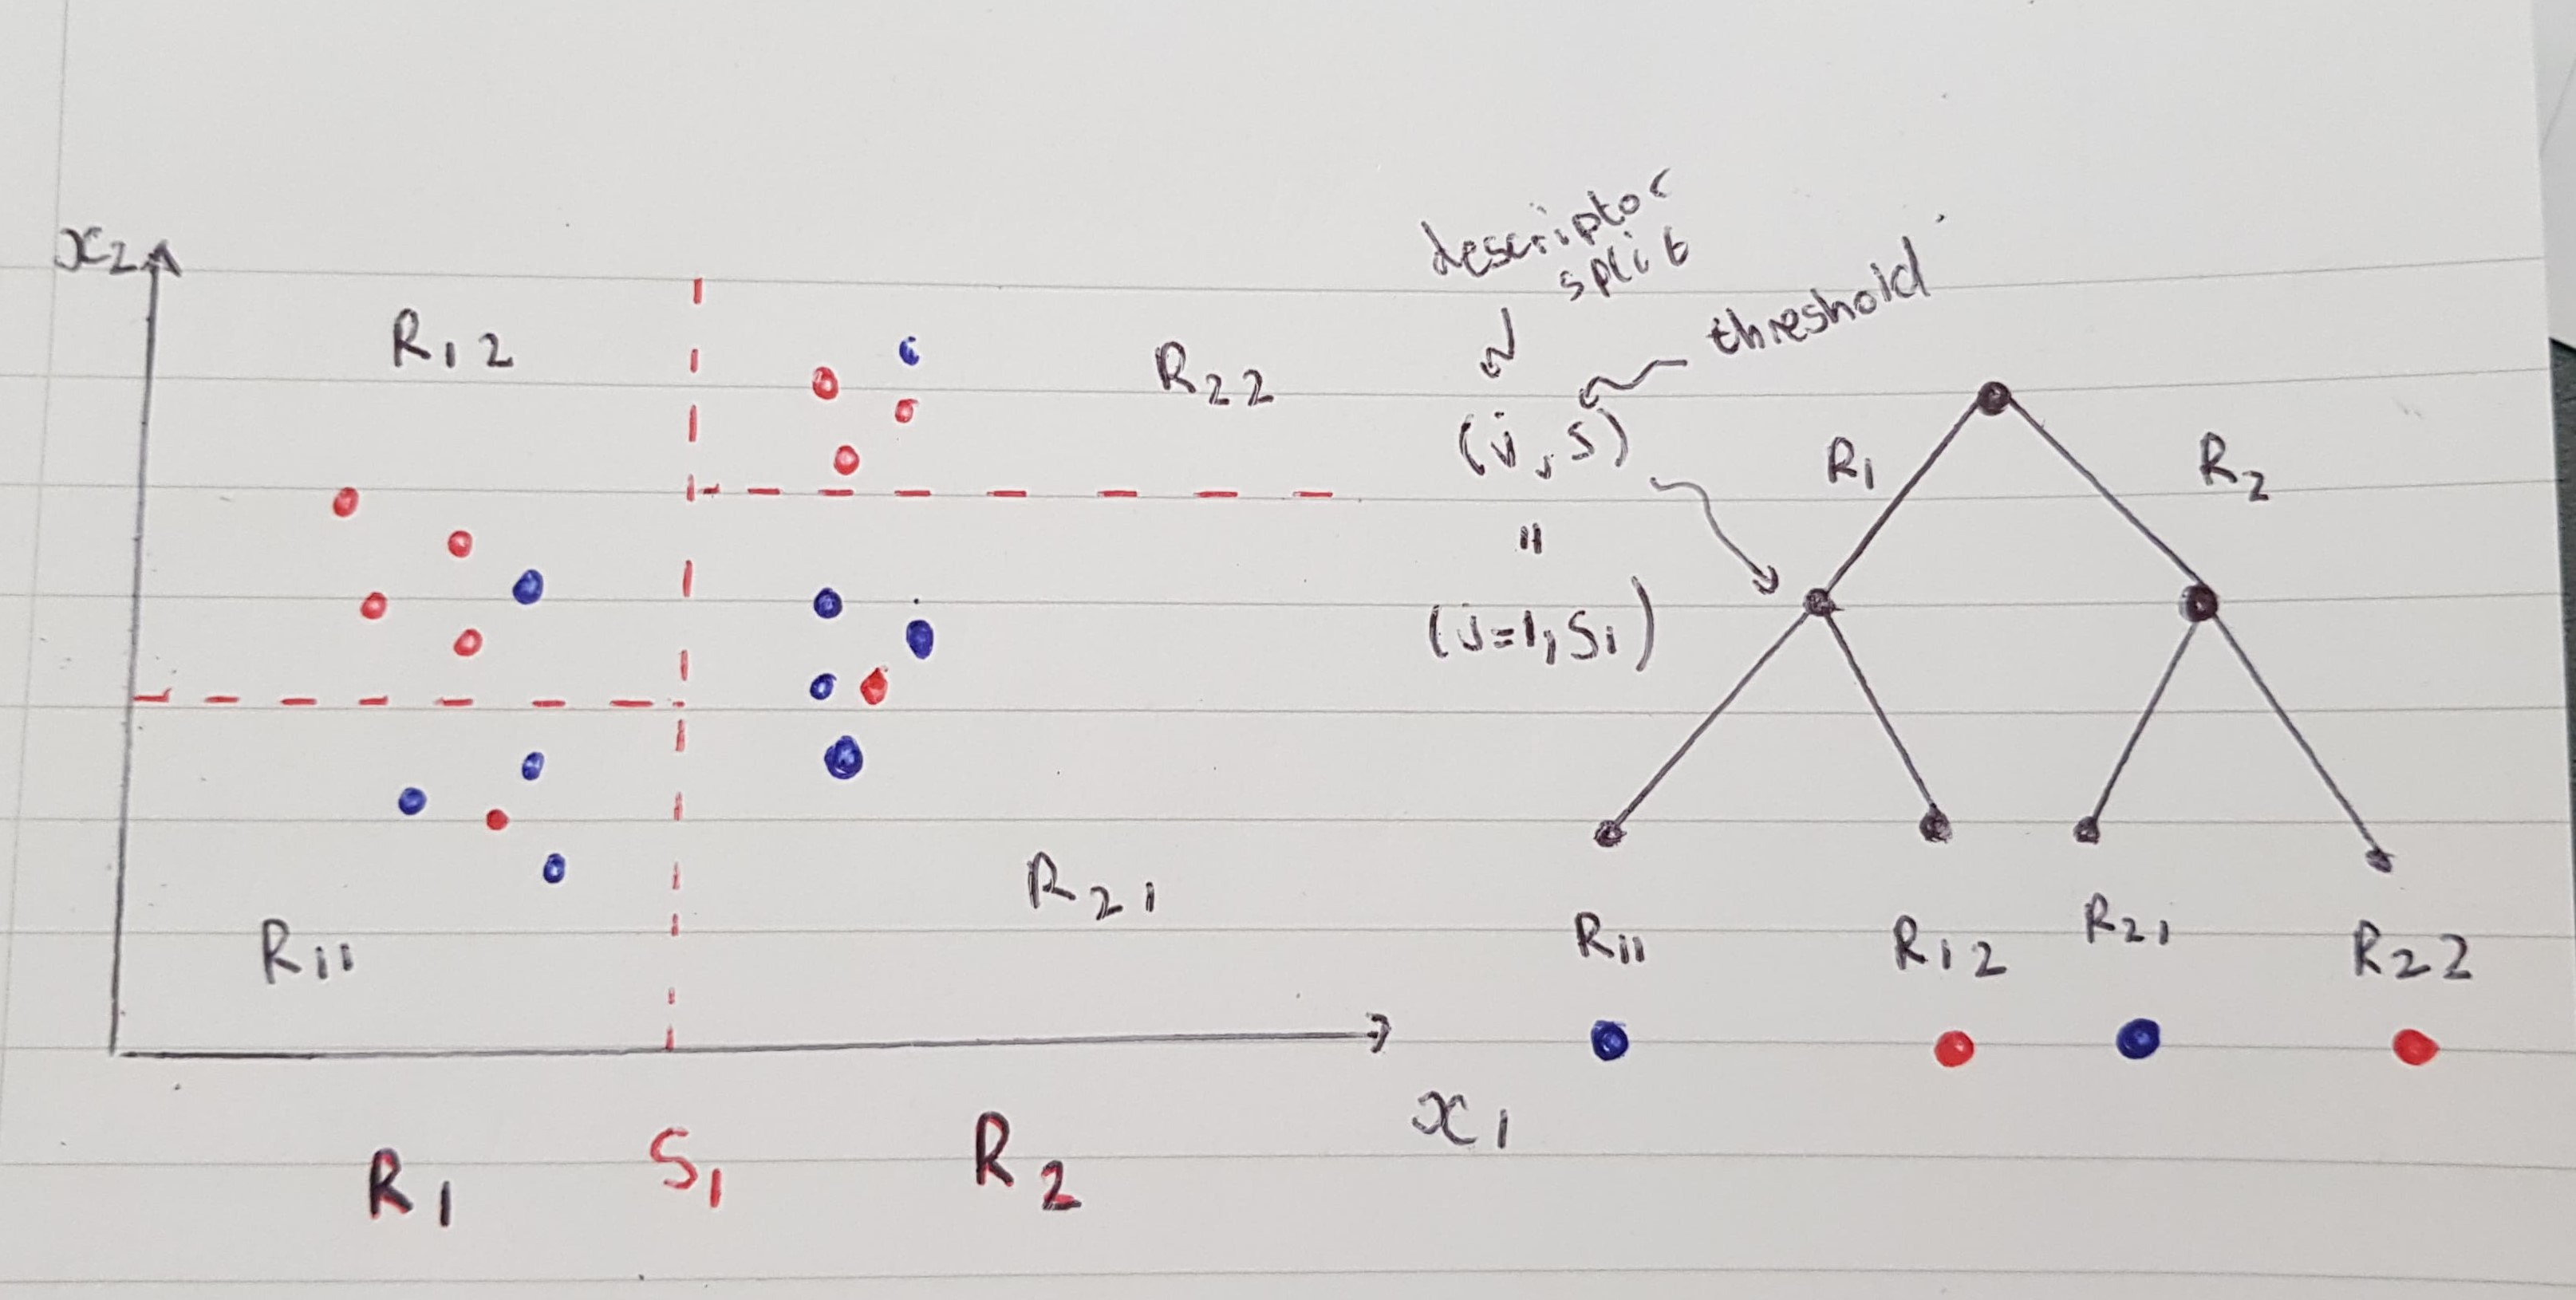

<u> Decision Trees For Classification </u>

To optimise decision trees at each split for classification the Gini Index is used as a cost function to minimise. Denoting $\Pi(R_{\vec{\alpha}})$ to be vector of the proportion of samples in a given class for the region $R_{\vec{\alpha}}$ the Gini Index is: $$GI[\Pi(R_{\vec{\alpha}})]= \sum\limits_{q=1}^{Q} \Pi(R_{\vec{\alpha}})_{q}(1 - \Pi(R_{\vec{\alpha}})_{q})$$ The Gini Index is a measure of how dissimilar the new regions produced from a split our to maximise the information gained from a split. Splits are made until a stopping criteria is met.

Optimising individual trees is a non-robust methodology which has significant changes for slight alterations to the training set. This leads to overfitting.

<u> Bootstrap Aggregation </u>


Bootstrap Aggregation (Bagging) is introduced to reduce variability to new data.

A production of B b random samples with replacement of size N from a set $S = \{\vec{x}^{(i)} \forall i \in {1, ..., N}\}$. For each of these B samples a Decision Tree is optimised,. This produces a collection of decision trees. Then to predict a sample each of the trees prediction vector for that sample is found, $\Pi(R_{\vec{\alpha}})$, for the region the sample falls in, the average of these vectors is found and the prediction is the arg max of the averaged vector.

<u> RF Classifier </u>

The outcomes are still correlated between trees because of the dominance of some descriptors. To mitigate this we restrict splits to a random set of descriptors. This process is summarised as:

(1) Generate bootstrap sample.

(2) Create a decision tree with the additional constraint that the number of descriptors available at each split is a subset of descriptors of size  $\tilde{p}$. The tree creation is stopped when a max depth of tree d is reached.

(3) This process is repeated for b random samples.

<u> Hyperparameters </u>

I will use 5-fold stratified cross-validation to optimise the following parameters.

**Number of decision trees:** The higher amount of trees you have will generally improve the perfomance however the convergence is generally quick so at a certain point the benefit in prediction performance from learning more trees will be lower than the cost in computation time for learning these additional trees. I will search over a log range numbers then optimise.

**Depth of trees:** For training if we set max_depth too high we will be at risk of overfitting whereas too low a depth we will have the converse issue of underfitting. So I will tests for depths in the range from 1 to 13 since we have 5620 data points and $n = 13$ is the lowest $n$ such that $2^{n} > 5000$.

 **Maximum number of features:** I will test for the full range of $\tilde{p}<p$ that is 1 to 5. 


# Overview of k-fold Cross Validation

Cross-validation is used to evaluate the quality of a machine learning model on unseen data. That is, to use a set limited samples from the data set not used to train the model, to evaluate the model accuracy.

k-fold evaluation is used as a opposed to a single training, validation split to improve the robustness of results by reducing the dependence on the choice of split.  

k-fold CV is summarised as follows:

1. Shuffle the dataset randomly.

2. Split the dataset into k groups

3. For each unique group:

    3.1. Take the group as a hold out or test data set
    3.2. Take the remaining groups as a training data set
    3.3. Fit a model on the training set and evaluate it on the test set
    3.4. Retain the evaluation score and discard the model
4. Summarise the quality of the model using the average of the model evaluation scores

I will use $k=5$ and ensure that the k groups are stratified. 

## Hyperparameter Optimisation.

I will use a grid search of 5-fold stratified cross-validation to optimise RF model accuracy. 

---

I'll start by writing a function to visualise the results of a grid search.

In [5]:
def grid_plot_3D(CV, params, fig_num):
    """A function which visulualises the accuracy of a RF model from a 3D grid 
    search.
    Input:
        CV: results of gridsearch CV.
        params: a dictonary of the parameters optimised.
        fig_num: figure number.
    """
    # params
    p, d, n = params['max_features'], params['max_depth'], params['n_estimators']
    # length of paramas
    N, M, K = len(d), len(p), len(n)

    # gets a 3D grid of results
    scores = RF_CV.cv_results_['mean_test_score']
    grid = scores.reshape(N, M, K)

    # min and max scores
    vmin = min(scores)
    vmax = max(scores)

    # create figure
    fig, axs = plt.subplots(1, K, figsize = (K*N/2, M*1.2), sharey=True)
    cbar_ax = fig.add_axes([.91, .15, .03, .75])

    # title
    fig.suptitle('Visualisation of RF Classifier Accuracy Optimisation (Fig.' + 
                 str(fig_num) + ')',
                 fontsize='15', y=1.02)
    for i, ax in enumerate(axs):
        # 2D grid
        data = grid[:, :, i]
        
        # z-axis
        ax.set_title('Decision Trees: ' +  str(n[i]))
        
        # makes plots
        if i != 0:
            sns.heatmap(data, vmin=vmin, vmax=vmax, ax=ax, xticklabels=p, 
                        yticklabels=d,cbar=False)
        else:
            sns.heatmap(data, vmin=vmin, vmax=vmax, ax=ax, xticklabels=p, 
                        yticklabels=d, cbar_ax = cbar_ax, 
                        cbar_kws={'label': 'Accuracy'})
            ax.set_ylabel('Max Depth')
        # sets x label
        ax.set_xlabel('Max Features')
    print('Best Score: ', RF_CV.best_score_, '\nBest Parameters: ',
          RF_CV.best_params_)
    return

Run a grid search of the parameters.

In [6]:
# RF classifier
RF = RandomForestClassifier(random_state=0)

# range of number trees
n = np.logspace(1, 4, 4, dtype=int)
# range of number of descriptors at each split
p = np.arange(2, 6)
# d depth of trees
d = np.arange(1, 14, 2)

# hyperparameters
params = {'n_estimators' : n, 'max_features': p, 'max_depth': d}

if init_run:
    # grid search of parameters
    RF_CV = GridSearchCV(RF, params, scoring='accuracy',verbose=2, 
                        cv=StratifiedKFold(shuffle=True, random_state=0))
    RF_CV.fit(X_train, y_train)

    # save results
    with open(root + 'RF_CV_1.sav', 'wb') as fp:
        pickle.dump(RF_CV, fp)
else:
    # load fitted model
    RF_CV = pickle.load(open(root + 'RF_CV_1.sav', 'rb'))

Plot of results.

Best Score:  0.41619217081850535 
Best Parameters:  {'max_depth': 11, 'max_features': 2, 'n_estimators': 100}


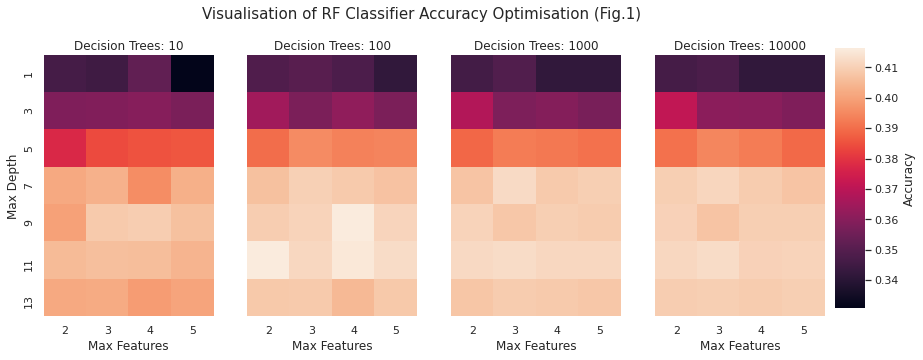

In [7]:
grid_plot_3D(RF_CV, params, 1)

From this plot we can see that values around max_depth: 11, max_features: 2 and n_estimators: 100 was best. 

I will now run a second refinement of this optimisation.

With max_depth: 8 to 12, max_features: 2 to 4 and n_estimators: 50 to 500.

In [8]:
# range of number trees
n = np.logspace(1.7, 2.7, 5, dtype=int)
# range of number of descriptors at each split
p = np.arange(2, 5)
# d depth of trees
d = np.arange(8, 13)

# hyperparameters
params = {'n_estimators' : n, 'max_features': p, 'max_depth': d}

if init_run:
    # grid search of parameters
    RF_CV = GridSearchCV(RF, params, scoring='accuracy',verbose=2, 
                        cv=StratifiedKFold(shuffle=True, random_state=0))
    RF_CV.fit(X_train, y_train)

    # save results
    with open(root + 'RF_CV_2.sav', 'wb') as fp:
        pickle.dump(RF_CV, fp)
else:
    # load fitted model
    RF_CV = pickle.load(open(root + 'RF_CV_2.sav', 'rb'))

Plot of results.

Best Score:  0.41601423487544487 
Best Parameters:  {'max_depth': 11, 'max_features': 2, 'n_estimators': 158}


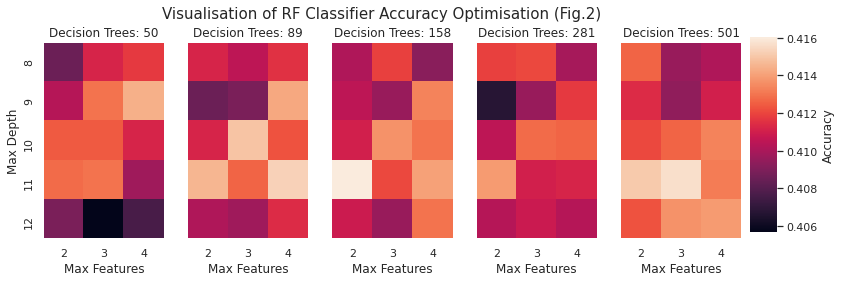

In [9]:
grid_plot_3D(RF_CV, params, 2)

From this plot we can see that values around max_depth: 11, max_features: 2 again for the refined search was best.

We now see n_estimators: 158 as the best number of decision trees this is worse than the score for n_estimators: 100. I will therefore fine tune from 90 to 157.

In [10]:
# range of number trees
n = np.arange(90, 158, 1)
# range of number of descriptors at each split
p = [2]
# d depth of trees
d = [11]

# hyperparameters
params = {'n_estimators' : n, 'max_features': p, 'max_depth': d}

if init_run:
    # grid search of parameters
    RF_CV = GridSearchCV(RF, params, scoring='accuracy',verbose=2, 
                        cv=StratifiedKFold(shuffle=True, random_state=0))
    RF_CV.fit(X_train, y_train)

    # save results
    with open(root + 'RF_CV_3.sav', 'wb') as fp:
        pickle.dump(RF_CV, fp)
else:
    # load fitted model
    RF_CV = pickle.load(open(root + 'RF_CV_3.sav', 'rb'))

Return result of optimum model.

Best Score:  0.41708185053380775 
Best Parameters:  {'max_depth': 11, 'max_features': 2, 'n_estimators': 99}


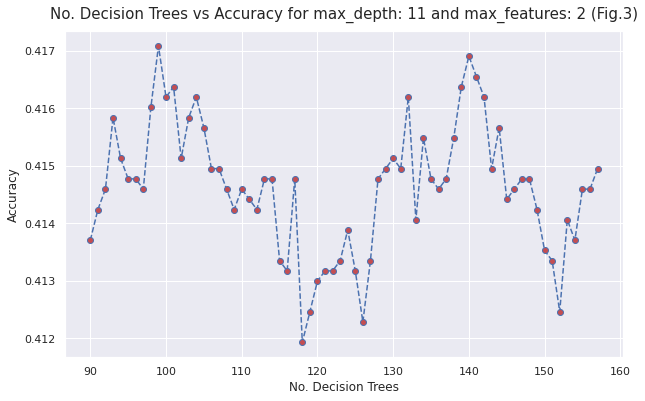

In [11]:
print('Best Score: ', RF_CV.best_score_, '\nBest Parameters: ',
          RF_CV.best_params_)

# plot results
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
ax.set_title('No. Decision Trees vs Accuracy for max_depth: 11 and ' \
             'max_features: 2 (Fig.3)', fontsize=15, y=1.02)
plt.plot(n, RF_CV.cv_results_['mean_test_score'], marker='o',
         markerfacecolor='r', linestyle='dashed')
ax.set_ylabel('Accuracy')
ax.set_xlabel('No. Decision Trees')

# optimum trained model 
RF = RF_CV.best_estimator_

# save best model
with open(root + 'RF.sav', "wb") as fp:
    pickle.dump(RF, fp)

## Discussion

I found that the best RF model in terms of 5-fold  validation accuracy for the oversampled data set of car data is a model with the following hyperparameters max_depth: 11, max_features: 2 and n_estimators: 99.

Fig.1 indicates that the max_depth parameter is the most important hyperparameter. This is displayed by the distinct horizontal strata visible in the heatmaps. Strata in accuracy suggest a high dependency of the model accuracy on a hyperparameter. This importance of depth is a result of the number of splits having a large impact on the amount of information stored in a decision tree and hence is highly correlated with the predictive power of a model. The more splits (greater) the more information stored but at the risk at high depths of overfitting.

We can then see in Fig.1 that the 2nd most important parameter is the max number of features (descriptors) with a visible but less dominant vertical strata visible. The max number of features has the importance of reducing the correlation between each of the random trees. 

For each number of estimators (decision trees) in Fig.1 we see a similar pattern for the heatmaps indicating a low importance of the number of estimators. This is expected since the number of decision trees merely improves on the issue of robustness of a single decision tree. The covergence of the increase in robustness is quick and after convergence has only a small effect on accuracy.

